In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
from functools import reduce
import datetime
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from utils import * 
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter, BiasedRandomWalk, TemporalRandomWalk
from scipy.special import softmax
from tqdm import tqdm

from math import isclose
from sklearn.decomposition import PCA
import multiprocessing
import sklearn.model_selection 
from gensim.models import Word2Vec
# python3 -m pip install tqdm seaborn 

2024-04-21 18:09:30.935616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# CM_Time()

In [6]:
class temporalNetwork(): 
    def __init__(self, start_date, end_date, display_progress=False, location_grouping='kma', origin=None, facility_id=None, intermediate=None):
        """ 
        Note: 
            start_date and end_date should be both None as they are used as a signal to 
            CM_Time's run_simulation to whether construct a new graph or update the graph with new information 
        """
        self.display_progress = display_progress
        self.start_date=start_date
        self.end_date=end_date
        self.network=None
        self.origin_location_list=None
        self.location_grouping=location_grouping
        self.inbound_data = None 
        self.outbound_data = None

    def construct_network_graph(self):
        """ 
        Given an inbound and outbound dataframe, construct a network graph and stores it in the class variable self.network
        Args: 
            an_inbound_df (pd.DataFrame): inbound dataframe
            an_outbound_df (pd.DataFrame): outbound dataframe
            start_date (datetime): start date of the network graph
            end_date (datetime): end date of the network graph
            location_grouping(string): 'kma' or 'zip3'
        """
        # pull data & construct an empty multiDiGraph

        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        an_inbound_df, an_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        an_inbound_df.load_date, an_outbound_df.load_date = pd.to_datetime(an_inbound_df.load_date), pd.to_datetime(an_outbound_df.load_date)
        for colin, colout in zip(an_inbound_df.columns, an_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                an_inbound_df[colin] = an_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                an_outbound_df[colout] = an_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, an_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, an_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, an_inbound_df, an_outbound_df, self.location_grouping)
        
        # update the variables 
        self.network = network_graph
        self.origin_location_list = an_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = an_inbound_df, an_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
        
    def move_to_next_week(self): 
        """ 
        Given the new week's inbound and outbound dataframes, 
        update self.network graph, self.start_date, and self.end_date to a week after current start date and end date 
        
        Args:
            next_inbound_df (pd.DataFrame): new week's inbound dataframe
            next_outbound_df (pd.DataFrame): new week's outbound dataframe
            display_progress (boolean): whether to display the progress of the function or not
        """
        # update the dates, pull new week's data, & store some informations
        self.start_date, self.end_date = self.start_date + timedelta(days=7), self.end_date + timedelta(days=7)
        date = self.start_date.strftime("%Y-%m-%d") + "_" + self.end_date.strftime("%Y-%m-%d")
        next_inbound_df, next_outbound_df = pd.read_csv(f"inbound_{self.location_grouping}_data/inbound_data_{date}.csv"), pd.read_csv(f"outbound_{self.location_grouping}_data/outbound_data_{date}.csv")
        next_inbound_df.load_date, next_outbound_df.load_date = pd.to_datetime(next_inbound_df.load_date), pd.to_datetime(next_outbound_df.load_date)
        for colin, colout in zip(next_inbound_df.columns, next_outbound_df.columns): 
            if colin not in ["total_loads", "load_date"]: 
                next_inbound_df[colin] = next_inbound_df[colin].astype(str)
            if colout not in ["total_loads", "load_date"]:
                next_outbound_df[colout] = next_outbound_df[colout].astype(str)

        network_graph = nx.MultiDiGraph(name=f"new network", start_date=self.start_date, end_date=self.end_date)
        # network_graph = nx.DiGraph(name=f"original network", start_date=self.start_date, end_date=self.end_date)
        # idf, odf = an_inbound_df.copy(), an_outbound_df.copy()

        # idf.to_csv(f"data/inbound_data_{self.start_date}_{self.end_date}.csv", index=False)
        # odf.to_csv(f"data/outbound_data_{self.start_date}_{self.end_date}.csv", index=False)

        # add nodes & edges 
        node_1 = f"origin_{self.location_grouping}_id"
        node_2 = f"facility_{self.location_grouping}_id"
        node_3 = f"destination_{self.location_grouping}_id"

        network_graph = add_nodes_given_df(network_graph, next_inbound_df, [node_1, 'facility_id']) 
        network_graph = add_nodes_given_df(network_graph, next_outbound_df, ['facility_id', node_2, node_3]) 

        network_graph = add_edges_given_graph(network_graph, next_inbound_df, next_outbound_df, self.location_grouping)

         # update the variables 
        self.network = network_graph
        self.origin_location_list = next_inbound_df[f'origin_{self.location_grouping}_id'].unique()
        self.inbound_data, self.outbound_data = next_inbound_df, next_outbound_df
        if self.display_progress: print(f"Current time of the graph: {self.start_date} to {self.end_date}") 
       

    def print_network_information(self, given_network, print_network_time=False): 
        """
        Given a network, print out the information of the network
        Args: 
            given_network (nx.MultiDiGraph): a network graph
        Returns: N/A
        """
        print("---------------------------------------------------------------------------------------------") 
        print(given_network)
        print(f"Is the given network a DAG for load_network?: {nx.is_directed_acyclic_graph(given_network)}")
        print(f"Number of self loops: {nx.number_of_selfloops(given_network)}")
        if print_network_time: print(f"Current time of the graph: {given_network.graph['start_date']} to {given_network.graph['end_date']}")
        else: print(f"Current time of the graph: {self.start_date} to {self.end_date}")


In [10]:
class CM_Finder():
    def __init__(self, location_grouping='kma', origin_location_list=None, network = None):
        self.network=network
        self.processed_network=None
        self.processed=False 
        self.origin_location_list=origin_location_list
        self.match_failure = None
        self.remove_failure = 0
        self.location_grouping=location_grouping
        
    def group_to_DiGraph(self, display_progress = False):
        """
        #TODO: explain why aggregate_faciility_zip then group_to_DiGraph (kma-> facility_zip -> kma to kma->kma->kma, aggregate to faciliy KMA)
        Assuming that self.network is constructed, 
        sums the edge weights for edges with the same nodes in self.network variable and 
        stores the new graph with aggregated edges in self.processed_network variable and returns False if successful 

        Args:
            display_progress (boolean): whether to display the progress of the function or not

        NOTE) disregards temporal factor 
        """
        if not self.network: 
            print("Please construct the network first")
            return None 
            
        new_name = self.network.name + " reduced"
        self.processed_network = nx.DiGraph(name=new_name)
        self.processed_network.add_nodes_from(self.network)

        if display_progress: print("Aggregating nodes by KMA...")
        for n1, n2 in self.network.edges():
            sum = 0 
            for inner_dict in self.network.get_edge_data(n1, n2).values(): 
                sum += inner_dict['capacity']
            self.processed_network.add_edge(n1, n2, capacity = sum)
        
        nx.set_edge_attributes(self.processed_network, to_integer(self.network.graph['end_date']), 'time')
        self.processed = True
        

In [11]:
class CM_Time(): 
    def __init__(self, location_grouping='kma', origin=None, facility_id=None, intermediate=None): 
        self.start_date=None
        self.end_date=None
        self.cm_network = None   
        self.cm_finder = None
        self.origin=origin
        self.facility_id=facility_id
        self.intermediate=intermediate
        self.location_grouping = location_grouping
        self.weekly_graphs = {}
    
    def update_dates(self): 
        """
        Updates the start and end date by 7 days
        """ 
        self.start_date += timedelta(days=7)
        self.end_date += timedelta(days=7)

    def construct_or_update_tg(self, filter_key='load_count', display_progress=False, display_path_info=False):
        """ 
        Either (1) creates a network graph given a start and end date 
            or (2) updates the network graph to the next week's graph 

        Args: 
            start_date, end_date: start & end date of the first two weeks of the simulation

        Returns: n/a
        """        
        # construct or update cm_finder.network 
        if not self.cm_network: 
            self.cm_network = temporalNetwork(self.start_date, self.end_date, display_progress, self.location_grouping, self.origin, self.facility_id, self.intermediate)
            self.cm_network.construct_network_graph()
            self.cm_finder = CM_Finder(location_grouping=self.location_grouping)
        else: 
            self.cm_network.move_to_next_week()

        self.cm_finder.origin_location_list = self.cm_network.origin_location_list
        self.cm_finder.network = self.cm_network.network
        
        # self.cm_finder.group_to_DiGraph(display_progress = display_progress)
        self.weekly_graphs[self.end_date] = self.cm_finder.network

    def temporal_query(self, start_date, temporal=True, looback = 7, number_of_weeks=None, termination_date = None, \
                    filter_key = "load_count", display_progress=False, display_path_info = False): 
        """
        Given a start date, run the simulation for number_of_weeks or until termination_date is reached.

        Args: 
            start_date: start date of the first week of the simulation
            temporal: if True, run the simulation for every two weeks, if False, run the simulation from start_date until end_date
            number_of_weeks: number of weeks to run the simulation for
            termination_date: date to stop the simulation
            filter_key: key to filter the network on (load_count or path_score)
            display_progress: if True, display progress bar
            display_path_info: if True, display path info

        Returns: a dictionary of simulation result for each week
            
        Note:
        * termination_date: termination date of the entire analysis, when end_date reaches termination_date, the query loop terminates,
        * end_date: the end date of the two-week window, will be updated every week

        - Once the parameters (location_grouping, origin, facility_id, intermediate) are used to initialise the cm_time class, 
          they will be used for any further analysis until new initialisation happens.
          query_weekly method will only perform analysis, no alterations can be made by calling solely this.

        - If temporal=True, --> end_date != termination_date, eventually at the end of simulations, end_date = termination_date
            and number_of_weeks is given, end_date = start_date + 13 days for the first simulation, termination_date = start_date + 7 days * number_of_weeks
            and termination_date is given, end_date = start_date + 13 days for the first simulation and termination_date=termination_date for the simulation
          If temporal=False --> end_date = termination_date 
            and number_of_weeks is given, end_date = start_date + 7 days * number_of_weeks for the simulation 
            and termination_date is given, end_date=termination_date for the simulation

        * simulation_results: a dictionary with key as the end_date and value as the simulation result
        """

        # create information needed for a new query with the given start_date and number_of_weeks
        # possible bug when end_date > termination_date.
        if temporal: 
            self.start_date, self.end_date = start_date, start_date + timedelta(days=looback-1)

            if number_of_weeks: termination_date = self.start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: termination_date = termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
        
            # run simulation for every two weeks until termination_date
            while self.end_date <= termination_date:    
                self.construct_or_update_tg(filter_key=filter_key, \
                                    display_progress=display_progress, display_path_info=display_path_info)
                self.update_dates() 
                
        else: 
            if number_of_weeks: self.start_date, self.end_date = start_date, start_date + timedelta(days=7) * number_of_weeks
            elif termination_date: self.start_date, self.end_date = start_date, termination_date
            else: raise Exception("Neither number of weeks nor termination date was given to set the simulation time period.")
            self.run_single_simulation(filter_key=filter_key, \
                                display_progress=display_progress, display_path_info=display_path_info)

        return self.weekly_graphs

    def if_edge(node1, node2, curr_graph): 
        adjacency_matrix = curr_graph

In [12]:
# construct graph old & new 
cm_time = CM_Time(location_grouping = 'zip3') 
weekly_graphs = cm_time.temporal_query(start_date=datetime(2021,1,1).date(), looback=7, termination_date= datetime(2023,6, 1).date(), \
                    display_progress=False, display_path_info = False)

# Helper functions

In [13]:
def operator_l2(u, v):
    return (u - v) ** 2

def operator_sub(u, v):
    return (u - v)


binary_operator = operator_l2

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


def link_examples_to_features(link_examples, transform_node):
    return [
        operator_l2(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]

def link_examples_to_features_sub(link_examples, transform_node):
    return [
        operator_sub(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter, penalty="l2") #, solver="liblinear")
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])

def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

# def labelled_links(positive_examples, negative_examples):
#     return (
#         positive_examples + negative_examples,
#         np.repeat([1, 0], [len(positive_examples), len(negative_examples)]),
#     )


# trw

In [14]:
def data_split(graph, prediction_window_size=2): 
    # graph = stellar graph
    # identify edges based on dates
    edges, weights = np.array(graph.edges(include_edge_weight=True)[0]), np.array(graph.edges(include_edge_weight=True)[1])
    lower_lim = sorted(list(set(weights)))[-prediction_window_size]
    index_test, index_train = np.where(weights >= lower_lim)[0], np.where(weights < lower_lim)[0]

    # create test & train edge sets
    test_edges, test_labels = edges[index_test], weights[index_test]
    train_edges, train_labels = edges[index_train], weights[index_train]
    test_weighted_edges = np.rec.fromarrays([test_edges[:,0], test_edges[:,1], test_labels])
    train_weighted_edges = np.rec.fromarrays([train_edges[:,0], train_edges[:,1], train_labels])
    # print(set(test_labels), set(train_labels))

    # create test and train graph 
    test_graph,train_graph = nx.MultiDiGraph(), nx.MultiDiGraph()
    test_graph.add_weighted_edges_from(test_weighted_edges,weight='time')
    train_graph.add_weighted_edges_from(train_weighted_edges,weight='time')
    test_graph, train_graph = StellarGraph.from_networkx(test_graph, edge_weight_attr='time', edge_type_attr='directed'), \
                        StellarGraph.from_networkx(train_graph, edge_weight_attr='time', edge_type_attr='directed'), 

    # create pos & neg edges 
    edge_splitter_test = EdgeSplitter(test_graph, graph)
    graph_test, examples_test, labels_test = edge_splitter_test.train_test_split( #result_graph, [u, v], edge_data_labels (1 or 0)
        p=0.1, method="global",
    )

    ## train graph 
    edge_splitter_train = EdgeSplitter(train_graph, graph)
    graph_train, examples, labels = edge_splitter_train.train_test_split(
        p=0.1, method="global"
    )
    
    # (
    #     examples_train,
    #     examples_model_selection,
    #     labels_train,
    #     labels_model_selection,
    # ) = sklearn.model_selection.train_test_split(examples, labels, train_size=0.75, test_size=0.25)

    # concatenate graph_train and train_graph as by time t, we have learned all previous edges up to t 
    test_graph_e = graph_test.edges(include_edge_weight=True)
    test_graph_edges, test_graph_weights= np.array(test_graph_e[0]),np.array(test_graph_e[1])
    test_weighted_edges = np.rec.fromarrays([test_graph_edges[:,0], test_graph_edges[:,1], test_graph_weights])
    train_graph_e = train_graph.edges(include_edge_weight=True)
    train_graph_edges, train_graph_weights= np.array(train_graph_e[0]),np.array(train_graph_e[1])
    train_weighted_edges = np.rec.fromarrays([train_graph_edges[:,0], train_graph_edges[:,1], train_graph_weights])
    union_graph_test = nx.MultiDiGraph()
    union_graph_test.add_weighted_edges_from(test_weighted_edges)
    union_graph_test.add_weighted_edges_from(train_weighted_edges)
    union_graph_test = StellarGraph.from_networkx(union_graph_test, edge_weight_attr='time', edge_type_attr='directed')

    if set(graph_train.edges(include_edge_weight=True)[1]).intersection(set(graph_test.edges(include_edge_weight=True)[1])): 
        raise(Exception)
    return union_graph_test, graph_test, examples_test, labels_test, graph_train, examples, labels #, examples_train,examples_model_selection,labels_train,labels_model_selection,

# union_graph_test, graph_test, examples_test, labels_test, graph_train, examples, labels = data_split(graph)
# print(len(graph_test.edges()), len(graph_train.edges()))
# print(set(graph_train.edges(include_edge_weight=True)[1]).intersection(set(graph_test.edges(include_edge_weight=True)[1])))
# graph_test, examples_test, labels_test, graph_train, examples, labels, examples_train,examples_model_selection,labels_train,labels_model_selection, = data_split(graph)

In [15]:
def temporal_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2): 
    num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)
    temporal_rw = TemporalRandomWalk(graph)
    temporal_walks = temporal_rw.run(
        num_cw=num_cw,
        cw_size=context_window_size,
        max_walk_length=walk_length,
        walk_bias="exponential",
    )
    
    embedding_size = 128
    temporal_model = Word2Vec(
        temporal_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,)

    unseen_node_embedding = np.zeros(embedding_size)

    def temporal_embedding(u):
        try:
            return temporal_model.wv[u]
        except KeyError:
            return unseen_node_embedding
    return temporal_embedding 

def static_model(graph, num_walks_per_node=10, walk_length = 10, context_window_size = 2): 
    static_rw = BiasedRandomWalk(graph)
    static_walks = static_rw.run(
        nodes=graph.nodes(), n=num_walks_per_node, length=walk_length
    )

    # print("Number of static random walks: {}".format(len(static_walks)))
    embedding_size = 128
    static_model = Word2Vec(
        static_walks,
        vector_size=embedding_size,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=2,
        epochs=1,
    )
    unseen_node_embedding = np.zeros(embedding_size)
    def static_embedding(u):
        try: 
            return static_model.wv[u]
        except KeyError:
            return unseen_node_embedding
    return static_embedding


In [16]:
def run_analysis(graph, display_progress=False): 
    union_graph_test, graph_test, examples_test, labels_test, graph_train, examples, labels = data_split(graph)

    num_walks_per_node = 10
    walk_length = 10
    context_window_size = 2
    num_cw = len(graph_train.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)

    # learn the classifier 
    temporal_embedding = temporal_model(graph_train)
    temporal_link_features = link_examples_to_features(examples, temporal_embedding)
    temporal_clf = link_prediction_classifier()
    temporal_clf.fit(temporal_link_features, labels)
    temporal_score_train = evaluate_roc_auc(temporal_clf, temporal_link_features, labels)
    if display_progress: print(f"Temporal Training Score (ROC AUC): {temporal_score_train:.2f}")

    # random walk on the test graph + train_graph & calculate test score
    temporal_embedding = temporal_model(union_graph_test)
    temporal_link_features_test = link_examples_to_features(examples_test, temporal_embedding)
    temporal_score_test = evaluate_roc_auc(temporal_clf, temporal_link_features_test, labels_test)
    if display_progress: print(f"Temporal Test Score (ROC AUC): {temporal_score_test:.2f}")

    # learn the classifier 
    static_embedding = static_model(graph_train)
    static_clf = link_prediction_classifier()
    static_link_features = link_examples_to_features(examples, static_embedding)
    static_clf.fit(static_link_features, labels)
    static_score_train = evaluate_roc_auc(static_clf, static_link_features, labels)
    if display_progress: print(f"Static Training Score (ROC AUC): {static_score_train:.2f}")

    # random walk on the test graph + train_graph & calculate test score
    static_embedding = static_model(union_graph_test)
    static_link_features_test = link_examples_to_features(examples_test, static_embedding)
    static_score_test = evaluate_roc_auc(static_clf, static_link_features_test, labels_test)

    if display_progress: print(f"Static Test Score (ROC AUC): {static_score_test:.2f}")
    return (temporal_clf, temporal_score_train, temporal_score_test), (static_clf, static_score_train, static_score_test)

In [17]:
train_errors, test_errors = defaultdict(list), defaultdict(list)
for time, graph in tqdm(weekly_graphs.items()): 
    graph = StellarGraph.from_networkx(graph, edge_weight_attr='time', edge_type_attr='directed')
    temporal_e, static_e = run_analysis(graph, True)
    train_errors['temporal'].append(temporal_e[1])
    test_errors['temporal'].append(temporal_e[2])
    train_errors['static'].append(static_e[1])
    test_errors['static'].append(static_e[2]) 

  0%|          | 0/126 [00:00<?, ?it/s]

** Sampled 133 positive and 133 negative edges. **
** Sampled 336 positive and 336 negative edges. **
Temporal Training Score (ROC AUC): 0.85
Temporal Test Score (ROC AUC): 0.89
Static Training Score (ROC AUC): 0.91


  1%|          | 1/126 [00:29<1:01:06, 29.33s/it]

Static Test Score (ROC AUC): 0.60
** Sampled 125 positive and 125 negative edges. **
** Sampled 474 positive and 474 negative edges. **
Temporal Training Score (ROC AUC): 0.88
Temporal Test Score (ROC AUC): 0.87
Static Training Score (ROC AUC): 0.88


  2%|▏         | 2/126 [00:57<59:45, 28.92s/it]  

Static Test Score (ROC AUC): 0.61
** Sampled 271 positive and 271 negative edges. **
** Sampled 352 positive and 352 negative edges. **


  2%|▏         | 2/126 [01:02<1:04:12, 31.07s/it]


KeyboardInterrupt: 

In [ ]:
# train_static_errors,test_static_errors = train_errors['static'],test_errors['static']
# train_temporal_errors,test_temporal_errors = train_errors['temporal'],test_errors['temporal']
# errors_pd = pd.DataFrame(train_static_errors, columns=['train_static'])
# errors_pd['test_static'] = test_static_errors
# errors_pd['train_temporal'] = train_temporal_errors
# errors_pd['test_temporal'] = test_temporal_errors
# errors_pd.to_csv("errors_node2vec_temporalVSstatic.csv")

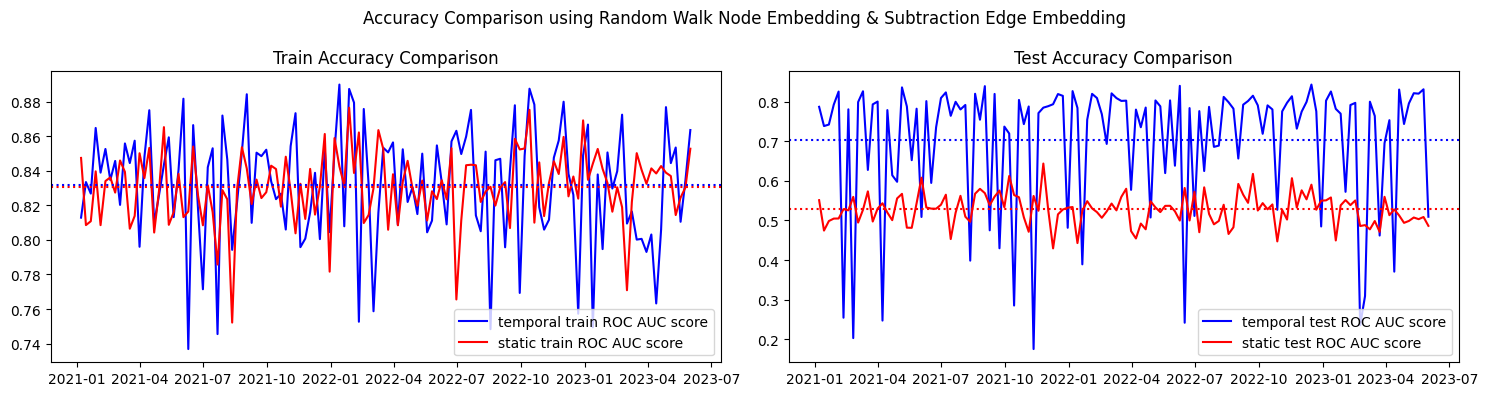

In [57]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.suptitle("Accuracy Comparison using Random Walk Node Embedding & Subtraction Edge Embedding")
date_list = weekly_graphs.keys()
ax[1].title.set_text("Test Accuracy Comparison")
ax[1].plot(date_list, test_errors['temporal'], label='temporal test ROC AUC score', color='blue')
ax[1].axhline(np.mean(test_errors['temporal']), linestyle=':', color='blue')
ax[1].plot(date_list, test_errors['static'], label='static test ROC AUC score',color='red')
ax[1].axhline(np.mean(test_errors['static']), linestyle=':',color='red')
ax[1].legend(loc='lower right')

ax[0].title.set_text("Train Accuracy Comparison")
ax[0].plot(date_list, train_errors['temporal'], label='temporal train ROC AUC score', color='blue')
ax[0].plot(date_list, train_errors['static'], label='static train ROC AUC score',color='red')
ax[0].axhline(np.mean(train_errors['temporal']), linestyle=':', color='blue')
ax[0].axhline(np.mean(train_errors['static']), linestyle=':',color='red')

ax[0].legend(loc='lower right')

fig.tight_layout()

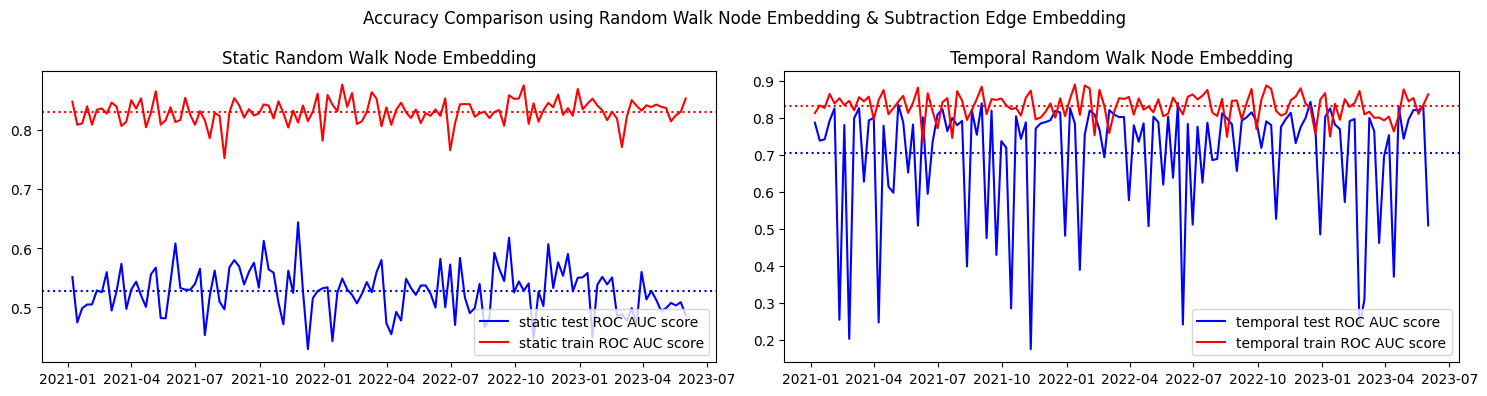

In [56]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
fig.suptitle("Accuracy Comparison using Random Walk Node Embedding & Subtraction Edge Embedding")
date_list = weekly_graphs.keys()
ax[1].title.set_text("Temporal Random Walk Node Embedding")
ax[1].plot(date_list, test_errors['temporal'], label='temporal test ROC AUC score',color='blue')
ax[1].axhline(np.mean(test_errors['temporal']), linestyle=':',color='blue')
ax[0].plot(date_list, test_errors['static'], label='static test ROC AUC score',color='blue')
ax[0].axhline(np.mean(test_errors['static']), linestyle=':',color='blue')

ax[0].title.set_text("Static Random Walk Node Embedding")
ax[1].plot(date_list, train_errors['temporal'], label='temporal train ROC AUC score', color='red')
ax[0].plot(date_list, train_errors['static'], label='static train ROC AUC score', color='red') #, color='orange')
ax[1].axhline(np.mean(train_errors['temporal']),  linestyle=':', color='red')
ax[0].axhline(np.mean(train_errors['static']), linestyle=':', color='red')

ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')

fig.tight_layout()

# data granualrity 
make it up and running for each day 
day 6 prediction: day 1 to day 5
day 7 prediction: day 2 to day 6 
etc. 